In [6]:
from utils.classes import EssayDataset
from utils.func import to_scores
import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import AutoTokenizer
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

import PySimpleGUI as sg
import re
import string
import matplotlib.pyplot as plt
import numpy as np
import torch

In [7]:
config = {
    'backbone': 'microsoft/deberta-v3-base',
    'model_path': './cache',
    'max_length': 512,

    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(
    config['backbone'], cache_dir=config['model_path'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
d:\ProgramData\Anaconda3\lib\site-packages\transformers\convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# 函数实现

In [8]:

def plot_radar_chart(avg_targets, avg_outputs=None):
    plt.rcParams['font.sans-serif'] = ['SimHei']

    labels = ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]
    avg_targets_plot = avg_targets + [avg_targets[0]]

    if avg_outputs:
        avg_outputs_plot = avg_outputs + [avg_outputs[0]]
        color1_1 = tuple(val / 255 for val in (240, 108, 169))
        color1_2 = tuple(val / 255 for val in (66, 187, 236))
        alpha_1 = 1
    else:
        avg_outputs_plot = None
        color1_1 = tuple(val / 255 for val in (64, 57, 144))
        alpha_1 = 0.7

    N = len(labels)
    theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
    labels += labels[:1]
    theta = np.concatenate([theta, [theta[0]]])

    ax = plt.subplot(111, projection="polar")
    
    # Set the maximum value of the radar to 5
    ax.set_ylim(0, 5)
    
    # 设置 y 轴的刻度位置
    ax.set_yticks([1, 2, 3, 4, 5])  # 新增这一行
    
    ax.fill(theta, avg_targets_plot, alpha=alpha_1, color=color1_1, label="目标均评分")
    
    if avg_outputs_plot:
        ax.fill(theta, avg_outputs_plot, alpha=0.3, color=color1_2, label="模型输出均评分")
        for i, (angle, value) in enumerate(zip(theta, avg_outputs_plot[:-1])):
            ax.annotate(str(round(value, 2)),
                        xy=(angle, value),
                        ha='center',
                        va='bottom',
                        fontsize=10,
                        color="black")

    ax.set_xticks(theta)
    ax.set_xticklabels(labels, fontweight='bold', position=(0, -0.2), verticalalignment='top',
                       horizontalalignment='center', fontsize=12)
    ax.set_yticklabels([1, 2, 3, 4, 5])
    ax.set_rlabel_position(30)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1))

    plt.show()


In [9]:
# 修改后的 test_essay 函数，现在返回一个包含评分的列表
def test(test_loader,model):

    preds = []

    # iterate test_loader
    for (inputs) in test_loader:
        inputs = {k: inputs[k].to(device=config['device'])
                  for k in inputs.keys()}

        outputs = model(inputs)
        preds.append(outputs.detach().cpu())

    preds = torch.concat(preds)
    return preds

def test_essay(essay, model):
    data = [[0, essay]]
    test_df = pd.DataFrame(
        data, columns=['text_id', 'full_text'], dtype=object)

    tokenizer = AutoTokenizer.from_pretrained(config['backbone'], cache_dir=config['model_path'])
    test_ds = EssayDataset(test_df, config, tokenizer=tokenizer, is_test=True)

    test_loader = torch.utils.data.DataLoader(test_ds,
                                              batch_size=1,
                                              shuffle=True,
                                              num_workers=0,
                                              pin_memory=True
                                              )

    model.eval()
    preds = test(test_loader,model)

    preds = to_scores(preds)

    print('cohesion: %.1f, syntax: %.1f, vocabulary: %.1f, phraseology: %.1f, grammar: %.1f, conventions: %.1f'
          % (preds[0][0], preds[0][1], preds[0][2], preds[0][3], preds[0][4], preds[0][5]))
    
    return preds[0].tolist()  # 返回评分列表

# 模型测试

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
d:\ProgramData\Anaconda3\lib\site-packages\transformers\convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


cohesion: 1.0, syntax: 1.5, vocabulary: 1.5, phraseology: 1.5, grammar: 2.0, conventions: 2.5


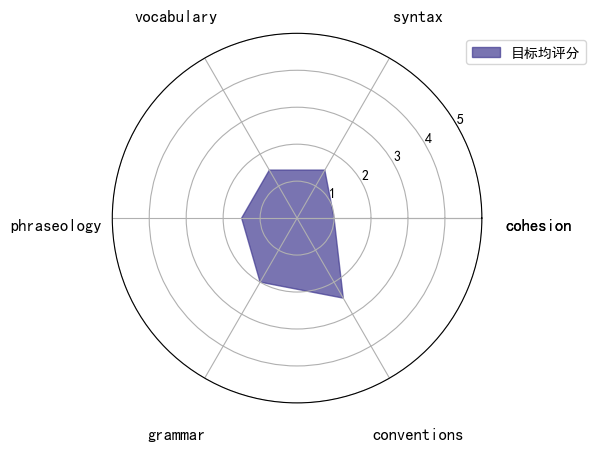

In [10]:
# 初始模型
essay = "you are really good.you are really good."
model_path = './checkpoints/FrozenBert-epochs3-val_mcrmse0.4411.pth'
model = torch.load(model_path)

# 使用 model_modified 生成评分
scores = test_essay(essay, model)

# 使用生成的评分绘制雷达图
plot_radar_chart(scores)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
d:\ProgramData\Anaconda3\lib\site-packages\transformers\convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


cohesion: 1.0, syntax: 1.5, vocabulary: 1.0, phraseology: 1.0, grammar: 1.0, conventions: 1.5


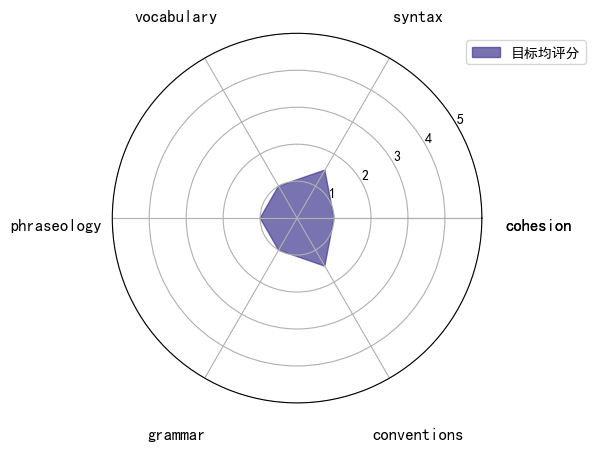

In [11]:
# 示例：使用不同的模型来评估同一篇文章
model_path = './checkpoints/DataEnhance_model-epochs5-val_mcrmse0.4988.pth'   #导入模型，这就是修改后的模型名称，还有路径，你要对上
model_modified = torch.load(model_path)

# 使用 model_modified 生成评分
scores = test_essay(essay, model_modified)

# 使用生成的评分绘制雷达图
plot_radar_chart(scores)


# GUI

./checkpoints/DataEnhance_model-epochs5-val_mcrmse0.4988.pth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
d:\ProgramData\Anaconda3\lib\site-packages\transformers\convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


cohesion: 1.0, syntax: 1.0, vocabulary: 1.0, phraseology: 1.0, grammar: 1.0, conventions: 0.5


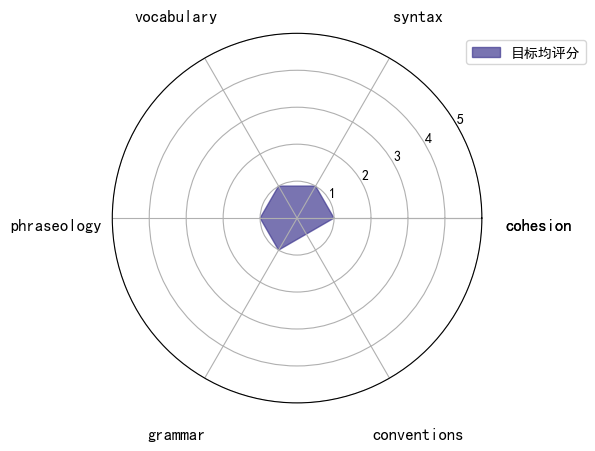

./checkpoints/FrozenBert-epochs3-val_mcrmse0.4411.pth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
d:\ProgramData\Anaconda3\lib\site-packages\transformers\convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


cohesion: 0.5, syntax: 0.5, vocabulary: 1.0, phraseology: 1.0, grammar: 1.0, conventions: 0.5


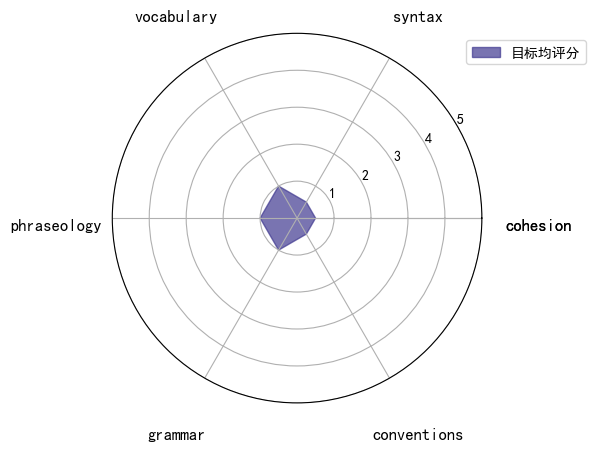

./checkpoints/DataEnhance_model-epochs5-val_mcrmse0.4988.pth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
d:\ProgramData\Anaconda3\lib\site-packages\transformers\convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


cohesion: 0.5, syntax: 1.0, vocabulary: 1.0, phraseology: 0.5, grammar: 0.5, conventions: 1.0


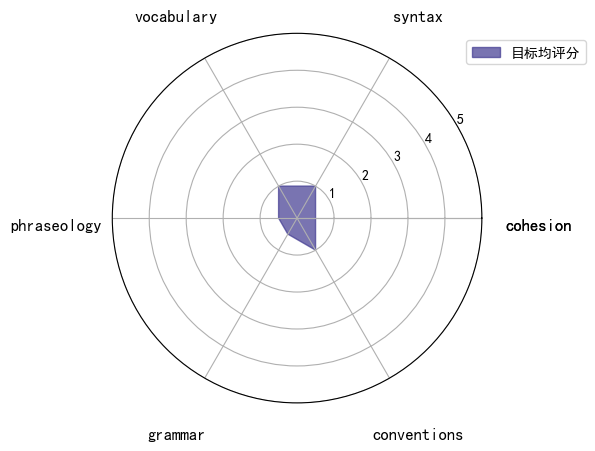

./checkpoints/FrozenBert-epochs3-val_mcrmse0.4411.pth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
d:\ProgramData\Anaconda3\lib\site-packages\transformers\convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


cohesion: 1.0, syntax: 1.5, vocabulary: 1.5, phraseology: 1.5, grammar: 2.0, conventions: 1.5


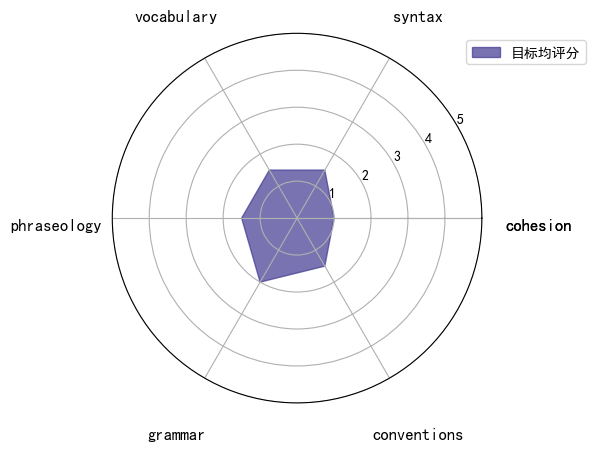

In [12]:

grade = '''您的分数是：
  syntax      : 
  vocabulary  :
  phraseology :
  grammar     :
  conventions :
'''

def plot_radar_chart(avg_targets, avg_outputs=None):
    plt.rcParams['font.sans-serif'] = ['SimHei']

    labels = ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]
    avg_targets_plot = avg_targets + [avg_targets[0]]

    if avg_outputs:
        avg_outputs_plot = avg_outputs + [avg_outputs[0]]
        color1_1 = tuple(val / 255 for val in (240, 108, 169))
        color1_2 = tuple(val / 255 for val in (66, 187, 236))
        alpha_1 = 1
    else:
        avg_outputs_plot = None
        color1_1 = tuple(val / 255 for val in (64, 57, 144))
        alpha_1 = 0.7

    N = len(labels)
    theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
    labels += labels[:1]
    theta = np.concatenate([theta, [theta[0]]])

    ax = plt.subplot(111, projection="polar")

    # Set the maximum value of the radar to 5
    ax.set_ylim(0, 5)

    # 设置 y 轴的刻度位置
    ax.set_yticks([1, 2, 3, 4, 5])  # 新增这一行

    ax.fill(theta, avg_targets_plot, alpha=alpha_1, color=color1_1, label="目标均评分")

    if avg_outputs_plot:
        ax.fill(theta, avg_outputs_plot, alpha=0.3, color=color1_2, label="模型输出均评分")
        for i, (angle, value) in enumerate(zip(theta, avg_outputs_plot[:-1])):
            ax.annotate(str(round(value, 2)),
                        xy=(angle, value),
                        ha='center',
                        va='bottom',
                        fontsize=10,
                        color="black")

    ax.set_xticks(theta)
    ax.set_xticklabels(labels, fontweight='bold', position=(0, -0.2), verticalalignment='top',
                       horizontalalignment='center', fontsize=12)
    ax.set_yticklabels([1, 2, 3, 4, 5])
    ax.set_rlabel_position(30)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1))

    plt.show()


def is_punctuation(char):
    if char in string.punctuation:
        return True
    else:
        return False


def alpha_number(string):
    return len(re.findall("[a-zA-Z]", string))


def is_alpha(string):
    return bool(re.match(r'[a-zA-Z]', string))


def is_number(string):
    pattern = re.compile(r'^[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?$')
    return bool(pattern.match(string))


def letter_count(string):
    if len(string) == 0:
        return 0
    mid = 0
    num = 0
    letter = 0
    while (1):
        if num == alpha_number(string):
            break
        if is_alpha(string[mid]) and num == alpha_number(string) - 1:
            letter = letter + 1
        if is_alpha(string[mid]) and num != alpha_number(string) - 1 and \
                (string[mid + 1] == ' ' or is_punctuation(string[mid + 1])):
            letter = letter + 1
        if is_alpha(string[mid]):
            num = num + 1
        mid = mid + 1
    return letter


def p_count(string):
    if len(string) == 0:
        return 0
    num = 1
    row = divmod(len(string), 80)[0] + bool(divmod(len(string), 80)[1] > 0)
    count = 0
    row_tensor = 0
    while (1):
        row_tensor = 0
        if num < row:
            row_tensor = string[80 * (num - 1):(80 * num - 1):1]
        if num == row:
            row_tensor = string[80 * (num - 1):(len(string) - 1):1]
        if alpha_number(row_tensor) > 0 and row_tensor[0] == ' ' and row_tensor[1] == ' ':
            count = count + 1
        if num == row:
            break
        num = num + 1
    return count


layout = [
    [sg.Text('欢迎进行作文批改!')],
    [sg.ML(default_text='请输入您的作文!', enable_events=True, size=(80, 25), key='paper')],
    [sg.B('短文章模型'), sg.B('长文章模型'), sg.Text('（默认短文章模型）')],
    [sg.B('点击这里查看您的作文分数!'), sg.Text('                                   总单词数为：0         总段落数为：0',
                                                key='alpha_and_p_number')],
    [sg.ML(default_text=grade, key='grades', size=(25, 7), visible=False)]
]
window = sg.Window('作文评分', layout)
model_path = './checkpoints/DataEnhance_model-epochs5-val_mcrmse0.4988.pth'
while True:
    event, value = window.read()
    if event == None:
        break
    if event == '短文章模型':
        model_path = './checkpoints/DataEnhance_model-epochs5-val_mcrmse0.4988.pth'
    if event == '长文章模型':
        model_path = './checkpoints/FrozenBert-epochs3-val_mcrmse0.4411.pth'
    if event == '点击这里查看您的作文分数!': 
        print(model_path)
        model_modified = torch.load(model_path)
        essay=test_essay(value['paper'], model_modified)
        window['grades'].update(visible=True,
        value='您的分数是：'+'\n'
        '    cohesion    :'+str(essay[0])+'\n'
        '    syntax      :'+str(essay[1])+'\n'
        '    vocabulary  :'+str(essay[2])+'\n'
        '    phraseology :'+str(essay[3])+'\n'
        '    grammar     :'+str(essay[4])+'\n'
        '    conventions :'+str(essay[5]))
 
            
        plot_radar_chart(essay, avg_outputs=None)

    if event == 'paper':
        text = '                                   总单词数为：' + str(
            letter_count(value['paper'])) + '         总段落数为：' + str(p_count(value['paper']))
        window['alpha_and_p_number'].update(value=text)
